In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

In [93]:

features = pd.read_csv("feature_presence540.txt", sep="\s+", header=None)

labels = pd.read_excel("aggregateRockData.xlsx")

# columns 4–14 → features, column 3 → token numbers, column 2 (from Excel) → label
X = features.iloc[:480, 3:14]
tokens = features.iloc[:480, 2].astype(int)
y = labels.iloc[:480, 1]

print(f"Features shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Features shape: (480, 11)
Labels shape: (480,)


In [94]:
print(X.head())
print(y.head())

     3     4     5    6     7     8    9     10   11    12    13
0  0.20  0.15  0.00  0.0  0.00  0.05  0.0  0.30  0.0  0.00  0.10
1  0.65  0.15  0.00  0.0  0.05  0.00  0.0  0.10  0.0  0.05  0.05
2  0.60  0.00  0.00  0.0  0.05  0.00  0.0  0.35  0.0  0.00  0.05
3  0.10  0.85  0.00  0.0  0.05  0.00  0.0  0.10  0.0  0.00  0.10
4  0.35  0.80  0.00  0.0  0.00  0.00  0.0  0.10  0.0  0.00  0.05
0    1
1    1
2    1
3    1
4    1
Name: 1.1, dtype: int64


In [95]:
print(X.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   3       480 non-null    object 
 1   4       480 non-null    object 
 2   5       480 non-null    object 
 3   6       480 non-null    float64
 4   7       480 non-null    float64
 5   8       480 non-null    float64
 6   9       480 non-null    float64
 7   10      480 non-null    float64
 8   11      480 non-null    float64
 9   12      480 non-null    float64
 10  13      480 non-null    float64
dtypes: float64(8), object(3)
memory usage: 41.4+ KB
None


In [96]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
6,480.0,0.042292,0.160970,0.0,0.0,0.00,0.0000,1.00
7,480.0,0.165146,0.216635,0.0,0.0,0.10,0.2125,0.95
8,480.0,0.052396,0.102676,0.0,0.0,0.00,0.0500,0.90
9,480.0,0.144479,0.265689,0.0,0.0,0.00,0.1000,1.00
10,480.0,0.141458,0.168222,0.0,0.0,0.10,0.2000,0.95
11,480.0,0.031667,0.135647,0.0,0.0,0.00,0.0000,1.00
12,480.0,0.025104,0.112153,0.0,0.0,0.00,0.0000,1.00
13,480.0,0.119854,0.173149,0.0,0.0,0.05,0.1500,1.00


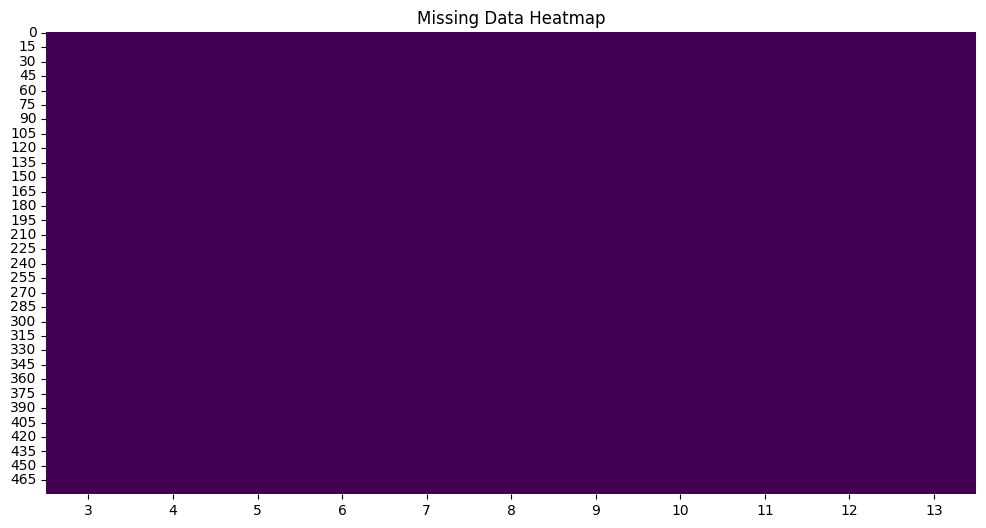

3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
dtype: int64


In [97]:
plt.figure(figsize=(12, 6))
sns.heatmap(X.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Data Heatmap")
plt.show()
print(X.isnull().sum())

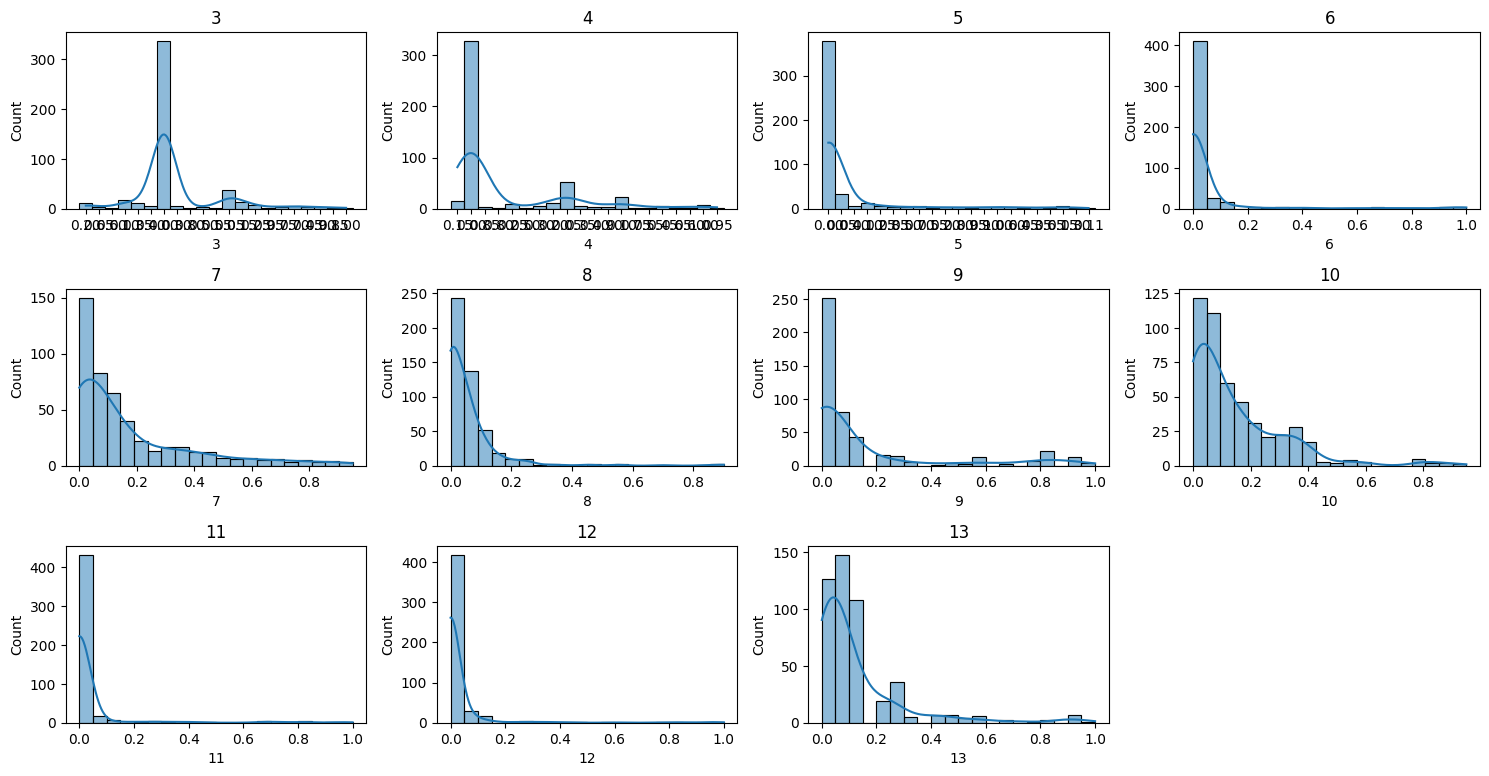

In [98]:
plt.figure(figsize=(15, 10))

for i, column in enumerate(X.columns, 1):
    plt.subplot(4, 4, i)
    sns.histplot(X[column], kde=True, bins=20)
    plt.title(column)

plt.tight_layout()
plt.show()

Missing values per column:
 3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
dtype: int64
 Missing values handled.
New feature shape: (480, 11)


,3,4,5,6,7,8,9,10,11,12,13
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.084479,0.080208,0.067729,0.042292,0.165146,0.052396,0.144479,0.141458,0.031667,0.025104,0.119854
std,0.193996,0.197648,0.194792,0.160970,0.216635,0.102676,0.265689,0.168222,0.135647,0.112153,0.173149
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.100000,0.000000,0.000000,0.050000
75%,0.050000,0.050000,0.000000,0.000000,0.212500,0.050000,0.100000,0.200000,0.000000,0.000000,0.150000
max,1.000000,1.000000,1.000000,1.000000,0.950000,0.900000,1.000000,0.950000,1.000000,1.000000,1.000000


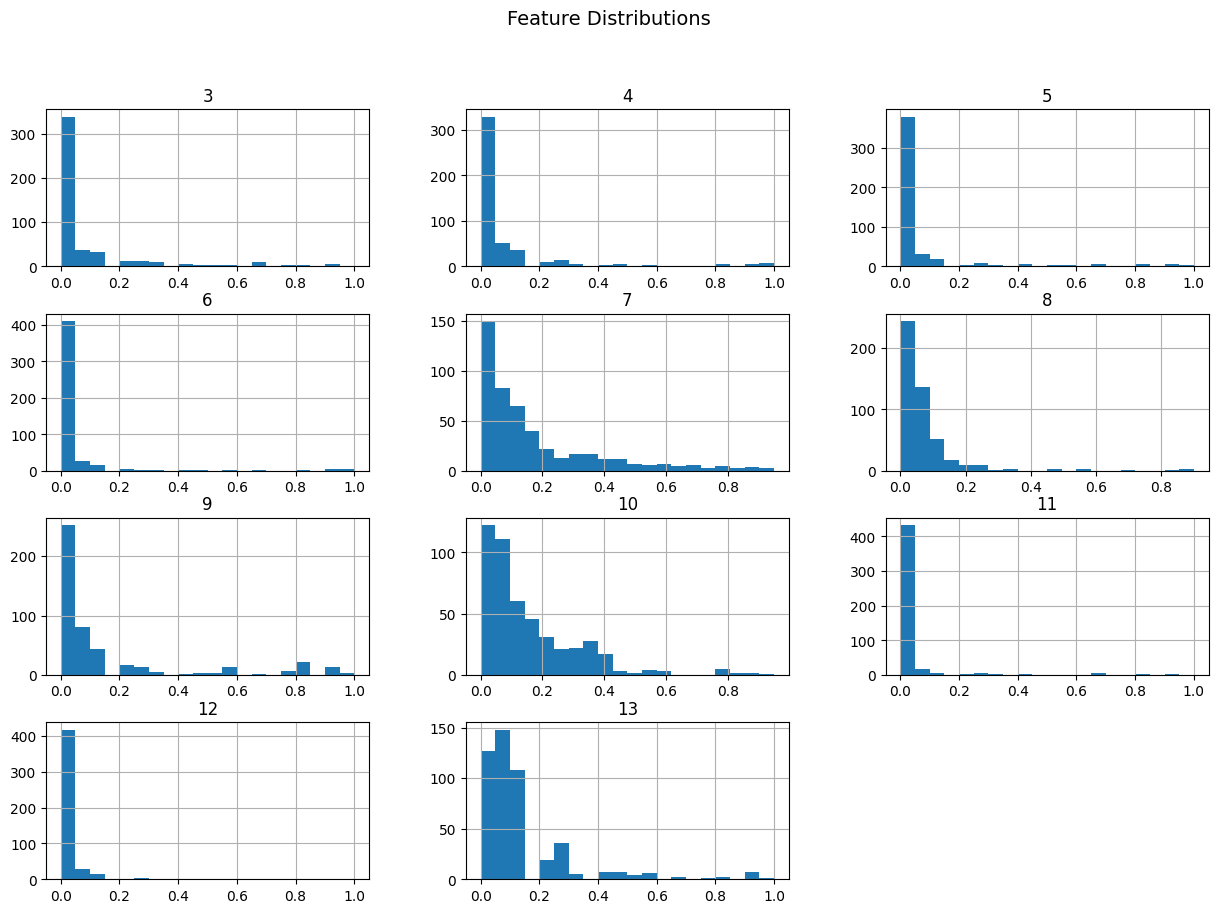

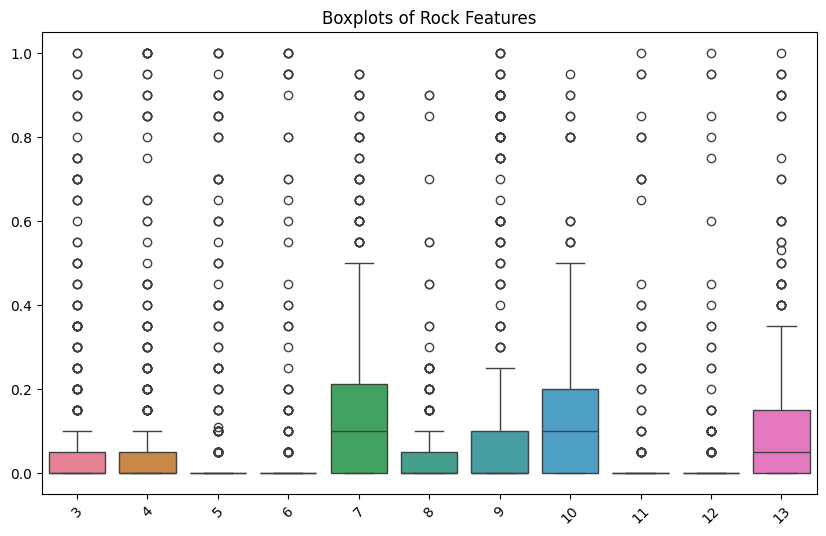

In [99]:
print("Missing values per column:\n", X.isna().sum())

imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

mask = y.notna()
X_imputed = X_imputed.loc[mask]
y_clean = y.loc[mask].astype(int)
tokens = tokens.loc[mask]

print(" Missing values handled.")
print(f"New feature shape: {X_imputed.shape}")
display(X_imputed.describe())

# Histograms
X_imputed.hist(bins=20, figsize=(15,10))
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

# Boxplots for outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=X_imputed)
plt.title("Boxplots of Rock Features")
plt.xticks(rotation=45)
plt.show()


ANSWER 1
-

Several attributes, particularly 5, 6, 7, 9, 11, and 12, are highly right-skewed with potential outliers. These features may benefit from log or square-root transformations to reduce skewness. Attributes like 3 and 4 have very low variance and might be removed or re-weighted.
-

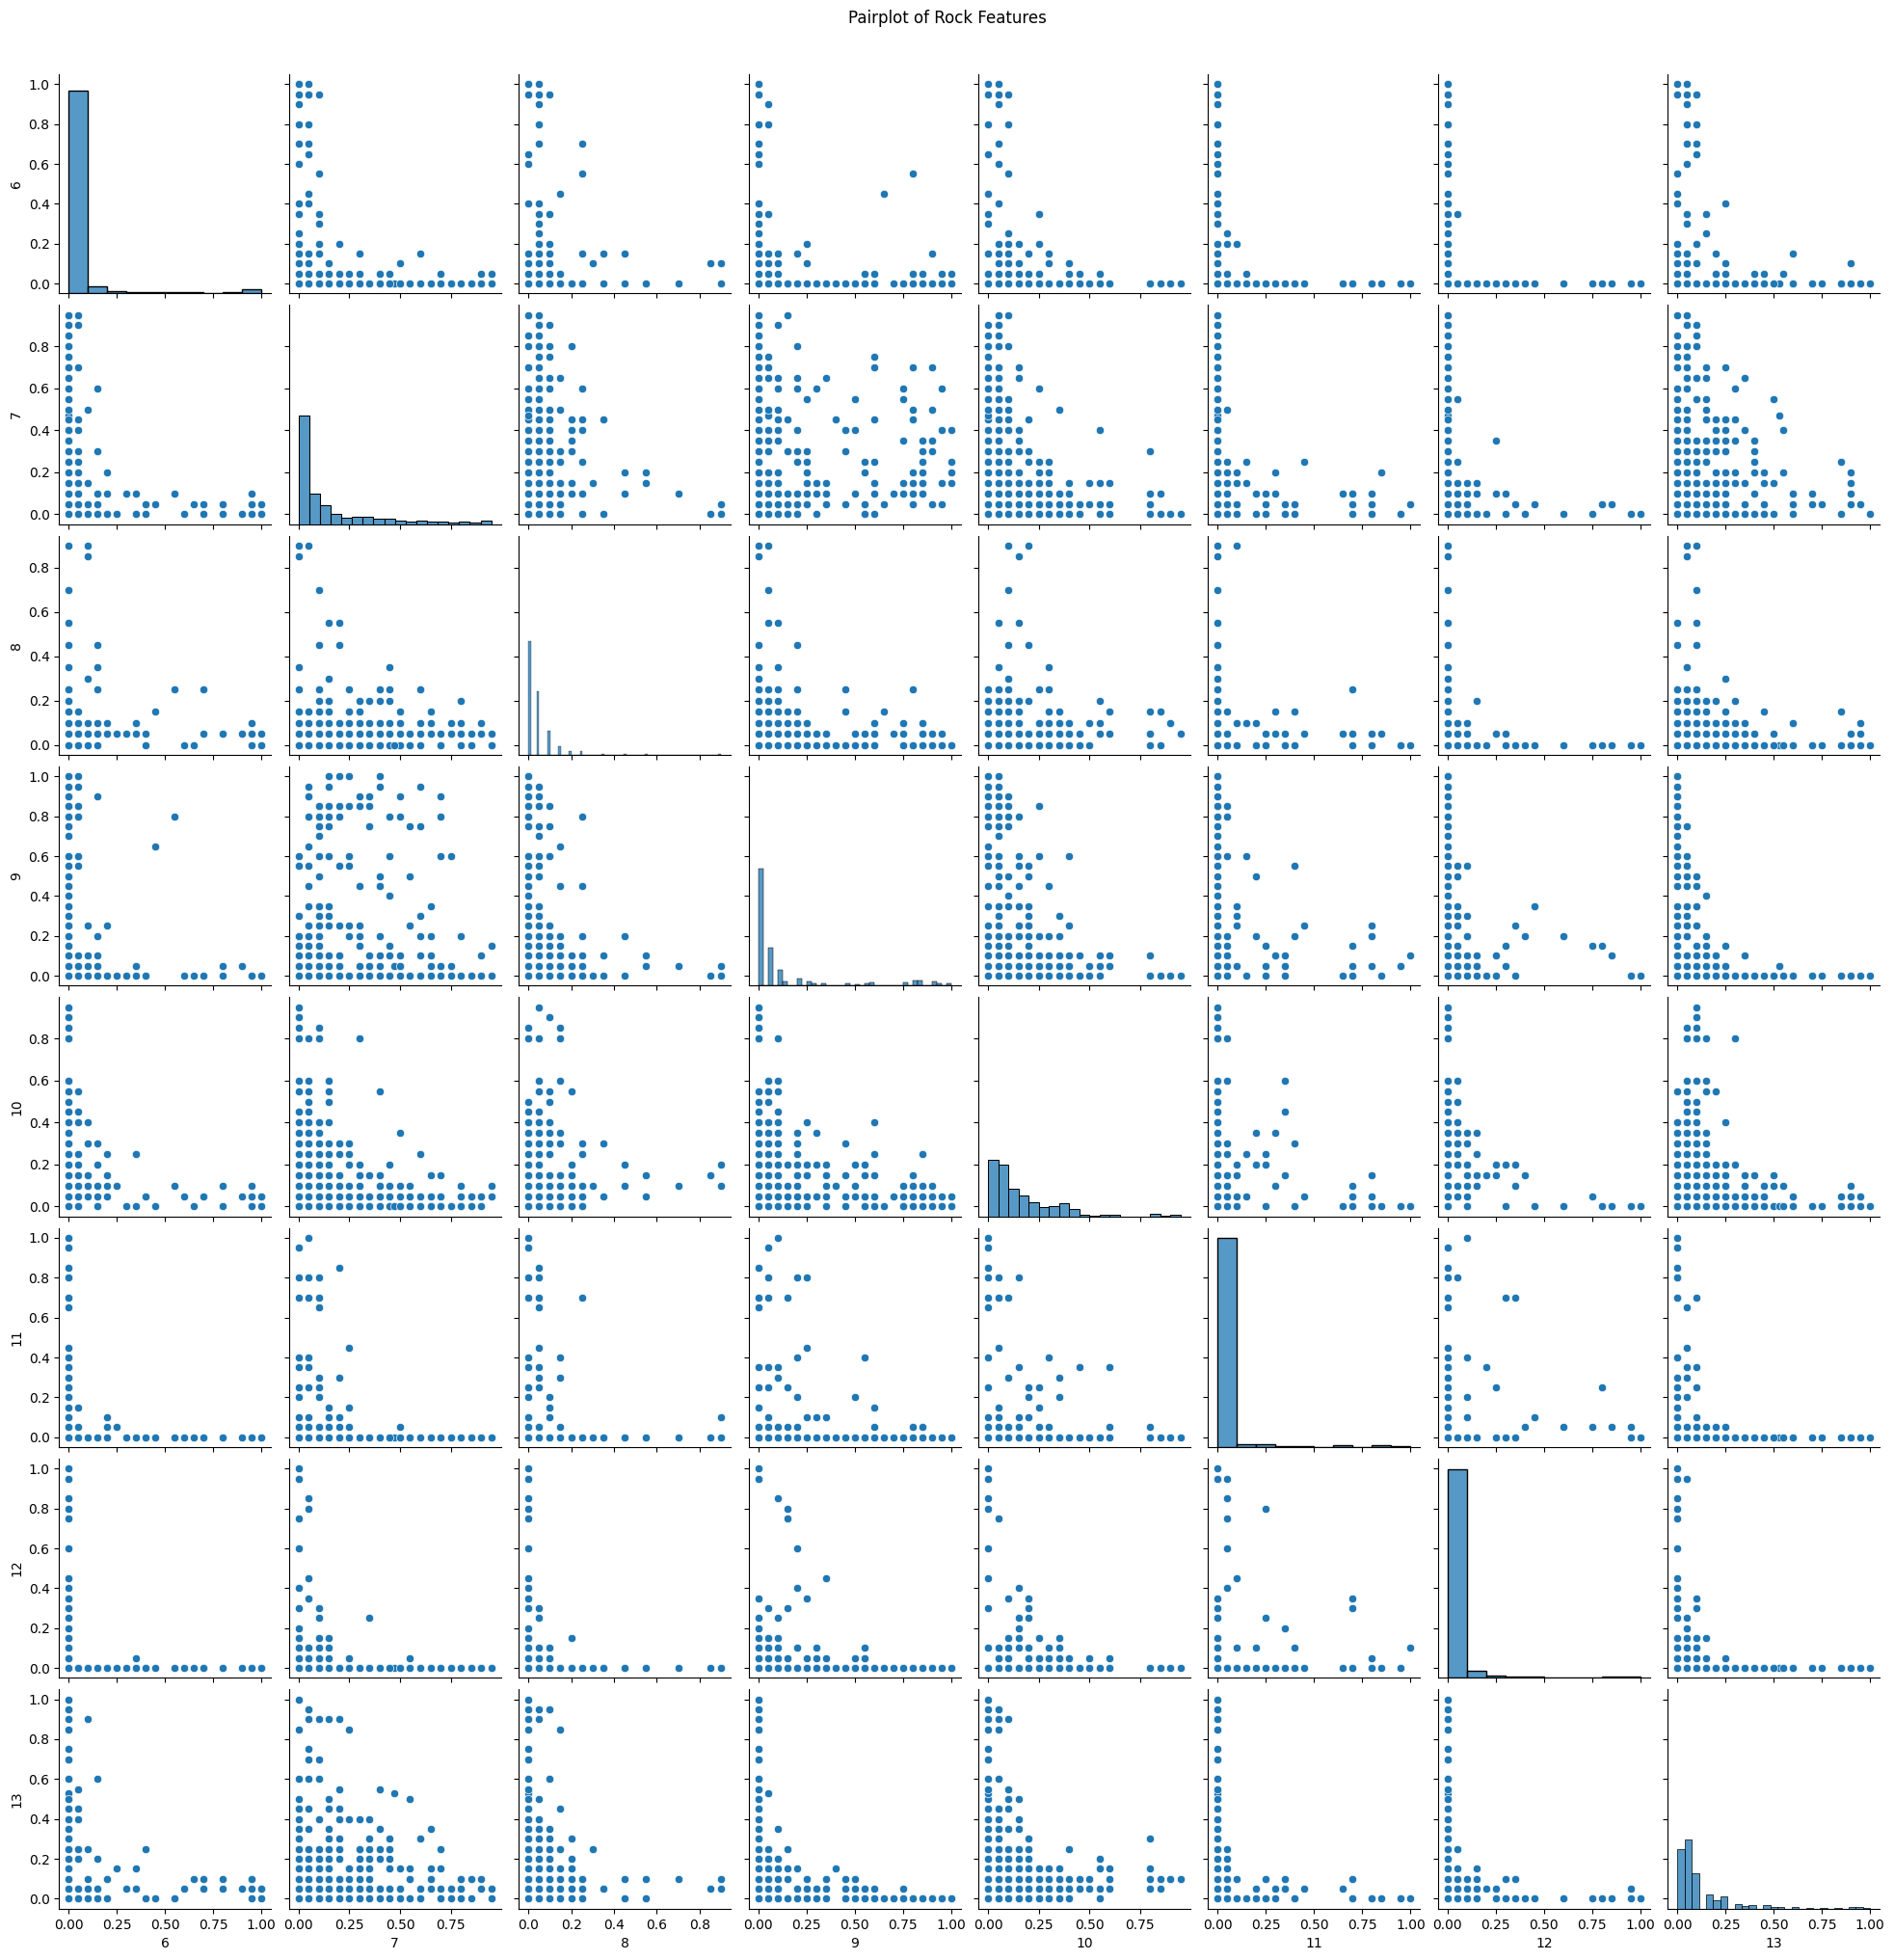

In [100]:
features = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]

sns.pairplot(X[features])
plt.suptitle("Pairplot of Rock Features", y=1.02)
plt.show()

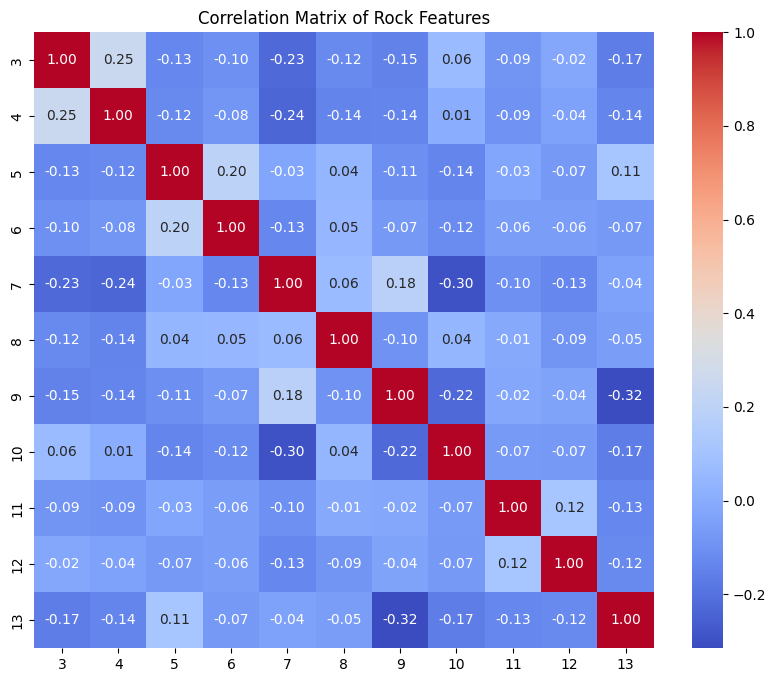


Feature–Label Correlations:
3                r = -0.120
4                r = 0.019
5                r = 0.077
6                r = -0.017
7                r = 0.266
8                r = 0.142
9                r = 0.008
10               r = -0.230
11               r = 0.259
12               r = 0.114
13               r = 0.143


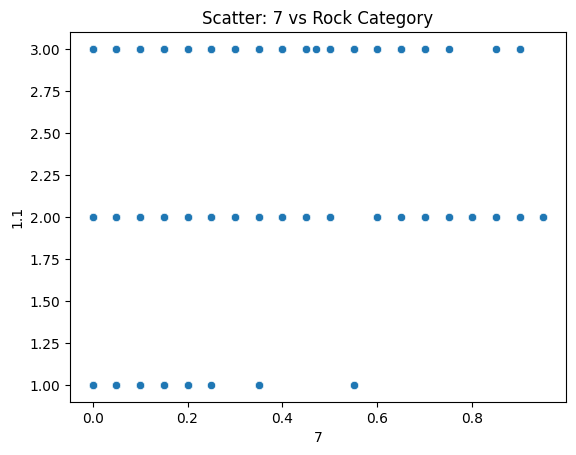

In [101]:
# Correlation Matrix Heatmap
corr = X_imputed.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Rock Features")
plt.show()

# Pearson correlation with labels
label_corr = [(col, np.corrcoef(X_imputed[col], y_clean)[0,1]) for col in X_imputed.columns]
print("\nFeature–Label Correlations:")
for name, r in label_corr:
    print(f"{str(name):15s}  r = {r:.3f}")


# Scatter plot for top correlated feature
top_feature = sorted(label_corr, key=lambda x: abs(x[1]), reverse=True)[0][0]
sns.scatterplot(x=X_imputed[top_feature], y=y_clean)
plt.title(f"Scatter: {top_feature} vs Rock Category")
plt.show()


Answer 2
-

The most notable correlations are negative, particularly between features 7 and 10 (-0.30) and features 9 and 13 (-0.32), suggesting inverse relationships that may indicate competing geological properties. The strongest positive correlation appears between features 5 and 6 (0.20), while features 3 and 4 show moderate correlation (0.25). Overall, most values fall between -0.15 and 0.15, indicating the features are largely orthogonal and capture distinct, non-redundant aspects of the rock samples, which is favorable for machine learning applications.
-

In [102]:
train_idx = tokens[tokens.between(7,16)].index
val_idx   = tokens[tokens.between(4,6)].index
test_idx  = tokens[tokens.between(1,3)].index

X_train, y_train = X_imputed.loc[train_idx], y_clean.loc[train_idx]
X_valid, y_valid = X_imputed.loc[val_idx], y_clean.loc[val_idx]
X_test, y_test   = X_imputed.loc[test_idx], y_clean.loc[test_idx]

print(f"Train: {X_train.shape}, Validation: {X_valid.shape}, Test: {X_test.shape}")


Train: (300, 11), Validation: (90, 11), Test: (90, 11)


Answer 3
-

Splitting data for Train, val and test
-

In [103]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_valid_s = scaler.transform(X_valid)
X_test_s  = scaler.transform(X_test)


Answer 4
-

4A
-

In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['lbfgs', 'newton-cg', 'saga'],
    'max_iter': [100, 500, 1000]
}

# Model
lr = LogisticRegression(multi_class='multinomial', random_state=42)

# Grid Search
grid_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='f1_macro', n_jobs=-1)
grid_lr.fit(X_train_s, y_train)

# Best model
best_lr = grid_lr.best_estimator_
print("Best parameters for Logistic Regression:", grid_lr.best_params_)

# Evaluate
def evaluate_model(model, X_tr, X_val, X_te, y_tr, y_val, y_te):
    results = {}
    for split, X, y in [('Train', X_tr, y_tr), ('Validation', X_val, y_val), ('Test', X_te, y_te)]:
        y_pred = model.predict(X)
        results[split] = {
            'Accuracy': accuracy_score(y, y_pred),
            'Precision': precision_score(y, y_pred, average='macro'),
            'Recall': recall_score(y, y_pred, average='macro'),
            'F1': f1_score(y, y_pred, average='macro')
        }
    return pd.DataFrame(results).T

lr_results = evaluate_model(best_lr, X_train_s, X_valid_s, X_test_s, y_train, y_valid, y_test)
lr_results


Best parameters for Logistic Regression: {'C': 1, 'max_iter': 100, 'solver': 'lbfgs'}


,Accuracy,Precision,Recall,F1
Train,0.713333,0.715915,0.713333,0.712396
Validation,0.633333,0.634697,0.633333,0.633226
Test,0.644444,0.658333,0.644444,0.638095


C controls regularization strength, balancing underfitting and overfitting. The solver determines the optimization algorithm used, affecting convergence speed and stability, especially on large or complex datasets. The maximum number of iterations sets how long the solver can run to find a solution; too low may prevent convergence, while higher values increase computation time but ensure proper training. Together, these hyperparameters manage model flexibility, training efficiency, and convergence reliability.

B
-

In [105]:
from sklearn.svm import SVC

# Define parameter grid
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

svm = SVC(probability=True, random_state=42)
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='f1_macro', n_jobs=-1)
grid_svm.fit(X_train_s, y_train)

best_svm = grid_svm.best_estimator_
print("Best parameters for SVM:", grid_svm.best_params_)

svm_results = evaluate_model(best_svm,X_train_s, X_valid_s, X_test_s, y_train, y_valid, y_test)
svm_results


Best parameters for SVM: {'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


,Accuracy,Precision,Recall,F1
Train,0.723333,0.734958,0.723333,0.720107
Validation,0.677778,0.689600,0.677778,0.675606
Test,0.688889,0.724640,0.688889,0.676643


C controls the tradeoff between margin width and training errors, with higher values reducing bias but increasing overfitting risk. The kernel defines the type of decision boundary, with options like linear, polynomial, or RBF affecting how well complex patterns are captured. Degree applies to polynomial kernels, determining boundary complexity, while gamma sets the influence of individual points low values create smoother boundaries, high values allow tighter fits. Together, these hyperparameters balance flexibility, bias, and variance.

C
-

In [106]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],           # number of trees
    'max_depth': [None, 10, 20, 30],          # maximum depth of each tree
    'min_samples_split': [2, 5, 10],          # minimum samples to split an internal node
    'min_samples_leaf': [1, 2, 4]             # minimum samples at a leaf node
}

best_rf = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(
    rf,
    param_grid_rf,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
print("Best parameters for Random Forest:", grid_rf.best_params_)

rf_results = evaluate_model(
    best_rf,X_train_s, X_valid_s, X_test_s, y_train, y_valid, y_test)
rf_results


Best parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


,Accuracy,Precision,Recall,F1
Train,0.716667,0.725669,0.716667,0.715867
Validation,0.577778,0.601209,0.577778,0.571419
Test,0.622222,0.640476,0.622222,0.620513


The number of trees (`n_estimators`) increases model stability and accuracy but also raises computation time. The maximum depth (`max_depth`) controls complexity—shallow trees may underfit, while deeper ones can overfit. The minimum samples to split (`min_samples_split`) and minimum samples per leaf (`min_samples_leaf`) prevent overfitting by limiting how finely the tree can divide data. Lower values make the model more flexible but prone to overfitting, whereas higher values simplify the model and improve generalization. Together, these hyperparameters balance accuracy, complexity, and efficiency.


Answer 5
-

In [107]:
ensemble = VotingClassifier(
    estimators=[("softmax", softmax), ("svm", best_model), ("rf", rf)],
    voting="soft"
)
ensemble.fit(X_train_s, y_train)

for name, (Xsp, ysp) in {"Validation": (X_valid_s, y_valid), "Test": (X_test_s, y_test)}.items():
    y_pred = ensemble.predict(Xsp)
    print(f"\n{name} Results")
    print(confusion_matrix(ysp, y_pred))
    print(classification_report(ysp, y_pred, digits=3))
    print(f"{name} Accuracy: {accuracy_score(ysp, y_pred):.3f}")



Validation Results
[[20  7  3]
 [ 5 21  4]
 [ 2  9 19]]
              precision    recall  f1-score   support

           1      0.741     0.667     0.702        30
           2      0.568     0.700     0.627        30
           3      0.731     0.633     0.679        30

    accuracy                          0.667        90
   macro avg      0.680     0.667     0.669        90
weighted avg      0.680     0.667     0.669        90

Validation Accuracy: 0.667

Test Results
[[24  3  3]
 [ 7 22  1]
 [ 6  9 15]]
              precision    recall  f1-score   support

           1      0.649     0.800     0.716        30
           2      0.647     0.733     0.688        30
           3      0.789     0.500     0.612        30

    accuracy                          0.678        90
   macro avg      0.695     0.678     0.672        90
weighted avg      0.695     0.678     0.672        90

Test Accuracy: 0.678


After combining the classifiers into an ensemble, the validation results showed improved performance compared with most individual models. The ensemble leveraged the strengths of different classifiers, reducing the weaknesses of any single one, and produced more stable and accurate predictions. Overall, the ensemble demonstrated better generalization on the validation set, indicating that combining diverse models can effectively boost predictive performance.

Asnwer 6
-

In [108]:
human = pd.read_csv("trialData.csv")
human.columns = [c.lower().strip() for c in human.columns]


Overall Human Accuracy (Block 4, rocks 1–480): 0.598
Softmax      Model Accuracy: 0.656
SVM          Model Accuracy: 0.689
RandomForest Model Accuracy: 0.700
Ensemble     Model Accuracy: 0.678

Columns in merged dataframe: Index(['human', 'Softmax', 'SVM', 'RandomForest', 'Ensemble'], dtype='object')


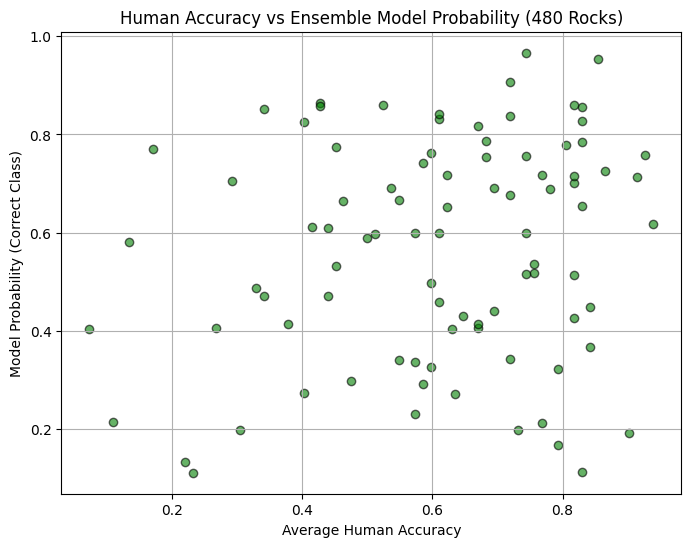


Correlation between Human Accuracy and Model Probability:
Softmax      → r = 0.148,  p = 0.166
   → Not significant
SVM          → r = 0.141,  p = 0.189
   → Not significant
RandomForest → r = 0.239,  p = 0.024
   → Significant correlation (p < 0.05)
Ensemble     → r = 0.189,  p = 0.076
   → Not significant


In [109]:

human = human.dropna(subset=["block", "rocknumber", "cat_correct"])
human["block"] = human["block"].astype(int)
human["rocknumber"] = human["rocknumber"].astype(int)
human["cat_correct"] = human["cat_correct"].astype(float)
human = human[(human["block"] == 4) & (human["rocknumber"] <= 480)]

# Compute average human accuracy per rock
human_acc = human.groupby("rocknumber")["cat_correct"].mean()

# === Compute overall human accuracy (train + test combined) ===
overall_human_acc = human["cat_correct"].mean()
print(f"Overall Human Accuracy (Block 4, rocks 1–480): {overall_human_acc:.3f}")


models = {
    "Softmax": softmax,
    "SVM": best_model,
    "RandomForest": rf,
    "Ensemble": ensemble
}

probs = {}

for name, model in models.items():
    
    if name in ["RandomForest"]:
        pred_proba = model.predict_proba(X_test)
        y_pred = model.predict(X_test)
    else:
        pred_proba = model.predict_proba(X_test_s)
        y_pred = model.predict(X_test_s)
        
    probs[name] = [pred_proba[i, y_test.iloc[i]-1] for i in range(len(y_test))]
    
    model_acc = (y_pred == y_test).mean()
    print(f"{name:12s} Model Accuracy: {model_acc:.3f}")

# === Combine human accuracies and model probabilities ===
probs_df = pd.DataFrame(probs, index=y_test.index)
human_df_named = pd.DataFrame({"human": human_acc})
combo = pd.concat([human_df_named, probs_df], axis=1, join="inner").dropna()

print("\nColumns in merged dataframe:", combo.columns)

# === Plot: Human accuracy vs Ensemble model probability ===
plt.figure(figsize=(8,6))
plt.scatter(combo["human"], combo["Ensemble"], color="green", alpha=0.6, edgecolor="black")
plt.xlabel("Average Human Accuracy")
plt.ylabel("Model Probability (Correct Class)")
plt.title("Human Accuracy vs Ensemble Model Probability (480 Rocks)")
plt.grid(True)
plt.show()

# === Compute correlations and p-values for all models ===
print("\nCorrelation between Human Accuracy and Model Probability:")
for name in ["Softmax", "SVM", "RandomForest", "Ensemble"]:
    r, p = pearsonr(combo["human"], combo[name])
    print(f"{name:12s} → r = {r:.3f},  p = {p:.3f}")
    if p < 0.05:
        print("   → Significant correlation (p < 0.05)")
    else:
        print("   → Not significant")


Model vs. Human Accuracy Comparison:
--

All four model types outperformed human accuracy of 59.8%. Softmax regression achieved 65.6%, SVM reached 68.9%, Random Forest attained the highest accuracy at 70.0%, and the Ensemble model achieved 67.8%. Random Forest demonstrated the most substantial improvement, surpassing human performance by 10.2 percentage points.

Correlation Analysis Between Human Accuracy and Model Confidence:
-

Random Forest showed the only statistically significant correlation (r = 0.239, p = 0.024), indicating its probability estimates moderately align with rocks that humans found easier or harder to classify. The Ensemble model showed marginal correlation (r = 0.189, p = 0.076) approaching significance, while Softmax (r = 0.148, p = 0.166) and SVM (r = 0.141, p = 0.189) exhibited weak, non-significant correlations. These results suggest that while Random Forest best captured human difficulty patterns, most models learned decision boundaries somewhat independently of human classification strategies.